<a href="https://colab.research.google.com/github/shashi3876/Ottawa_Data/blob/main/Ottawa_Data_Part_2_Finding_Periodicity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis of City of Ottawa Monthly Service Data

This is a continuation of the work done in the previous notebook. Here we mainly focus on the number of service calls per day. Thus, the initial data processing with cleaning the ward names will not be required. Furthermore, here we will utilize more data compared (previuos work was only for the data of year 2022). Here we would like to load as much as data possible.

As previuosly mentioned in the other notebook, this data is freely available on the data [portal](https://open.ottawa.ca/search?collection=Dataset&q=service) offered by city of Ottawa. The data portal states the following regarding these data.

*The data provides a summary of requests for service that require action by City staff.The data provides a summary of requests for service that require action by City staff. Data is presented by ward and shows the responsible City department and service request description.*

I have downloaded the available service call data in to my google drive. Lets load these data for the year 2019-2022.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


file_path = '/content/gdrive/My Drive/Colab Notebooks/Data/SR-2019.xlsx'
records2019 = pd.read_excel(file_path)#,encoding='utf16')

file_path = '/content/gdrive/My Drive/Colab Notebooks/Data/SR-2020.xlsx'
records2020 = pd.read_excel(file_path)#,encoding='utf16')

file_path = '/content/gdrive/My Drive/Colab Notebooks/Data/2021_Monthly_Service_Requests_EN.xlsx'
records2021 = pd.read_excel(file_path)#,encoding='utf16')

file_path = '/content/gdrive/My Drive/Colab Notebooks/Data/2022_Monthly_Service_Requests.csv'
records2022 =pd.read_csv(file_path)

Everything seems working correctly. Now lets concat the four dataframes in to a single dataframe along the axis 0 (rows).

In [3]:
records=pd.concat([records2019,records2020,records2021,records2022],axis=0)


# Getting data for each day

Here we'll aggeragte the service requests for each day and obtain a new dataframe for further processing. Also lets plot the whole graph and a zoomed in part of the graph.

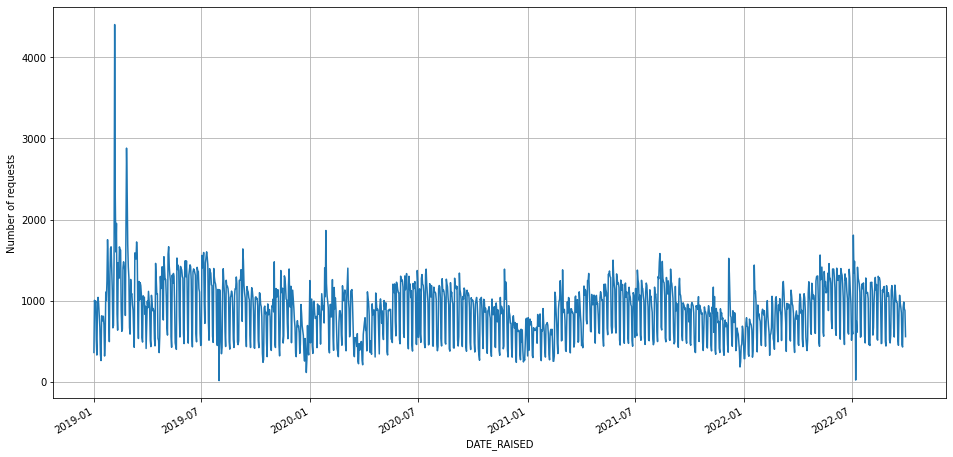

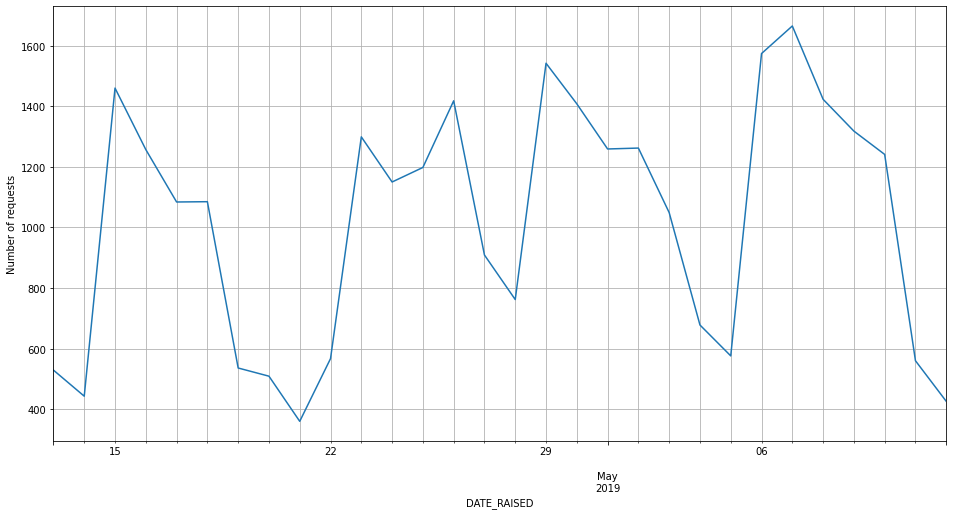

In [4]:
records["DATE_RAISED"]=pd.to_datetime(records.DATE_RAISED)
record_by_date=records.groupby("DATE_RAISED")["TYPE"].count().sort_index()
record_by_date.plot(figsize = (16, 8))
plt.ylabel('Number of requests')
plt.grid(visible=True,which='both')
plt.figure()

record_by_date.iloc[100:130].plot(figsize = (16, 8))
plt.ylabel('Number of requests')
plt.grid(visible=True,which='both')

#Check for missing dates

Now lets check if any of the dates are missing in our timeseries.

In [5]:
start_date = record_by_date.index.min()
end_date = record_by_date.index.max()

# create a complete date range for the period of interest
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# compare the date range to the index of the time series
missing_dates = date_range[~date_range.isin(record_by_date.index)]

if len(missing_dates) > 0:
    print("Missing dates:", missing_dates)
else:
    print("No missing dates")


Missing dates: DatetimeIndex(['2019-01-31', '2019-03-31', '2021-12-31'], dtype='datetime64[ns]', freq=None)


There are 3 missing dates in our timeseries. Lets add these dataes to the index and fill their values with the average of the neighbouring dates.

In [6]:
# Reindex to fill missing dates
idx = pd.date_range(start=record_by_date.index.min(), end=record_by_date.index.max(), freq='D')
record_by_date = record_by_date.reindex(idx, fill_value=0)

# Add missing dates with average of surrounding values
for date in missing_dates:
    prev_date = date - pd.DateOffset(days=1)
    next_date = date + pd.DateOffset(days=1)
    prev_val = record_by_date.loc[prev_date] if prev_date in record_by_date.index else np.nan
    next_val = record_by_date.loc[next_date] if next_date in record_by_date.index else np.nan
    avg_val = np.nanmean([prev_val, next_val])
    record_by_date.loc[date] = avg_val

# Finding the periodicity

Now after all those preprocessing steps, lets try to detect the period of this timeseries. In general, based on the holiday patterns and the general human routine we expect to see a period of seven days in our data. However, since this is a real-life data set, we may not be able to get clear results for the period.


From the above graph it seems like there is a weekly periodicity. As an example, the lowest values occur on May 14,21, and 28. Surprizingly these days corresponds to Tuesday. Now lets try to detect this periodicty using programming methods.

## Autocorrelation Analysis

Here, we'll plot the autocorrelation values of the timeseries. We'll look at the peaks of the acf plot for various lag values. The lag corresponding to the first significant peak can give an estimate of the period.

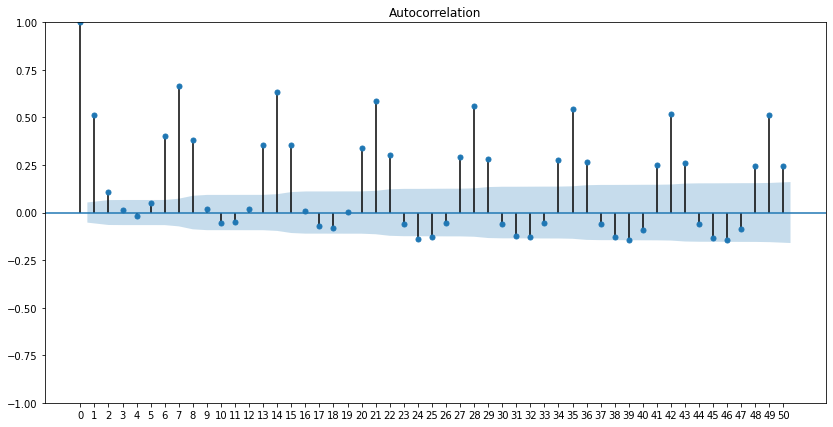

In [7]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(14,7))
plot_acf(record_by_date.values.squeeze(), lags=50,ax=ax,title='Autocorrelation', use_vlines=True);
lags = list(range(51))
ax.set_xticks(lags);
ax.set_xticklabels(lags);

It can be seen from the above plot that there are peaks at 7, 1, 21 etc. This confirms that our timeseries has a period of 7 days.

## Fourier analysis

Here, we perform a Fourier transform of the time series and look for the dominant frequency component. The inverse of the dominant frequency gives an estimate of the period.

The Fourier transform is a mathematical operation that decomposes a complex signal into a set of simpler sine and cosine waves. The [Fourier transform](https://en.wikipedia.org/wiki/Fourier_transform) is widely used in signal processing, communications, image processing, and many other areas of science and engineering. It allows us to analyze and manipulate signals in the frequency domain, which is often a more natural and intuitive way to understand and work with signals than in the time domain.



In [8]:
from scipy.fft import fft

# Calculate the Fourier transform
yf = np.fft.fft(record_by_date)
xf = np.linspace(0.0, 1.0/(2.0), len(record_by_date)//2)

# Find the dominant frequency
# We have to drop the first element of the fft as it corresponds to the 
# DC component or the average value of the signal
idx = np.argmax(np.abs(yf[1:len(record_by_date)//2]))
freq = xf[idx]

period =(1/freq)
print(f"The period of the time series is {period}")

The period of the time series is 7.005128205128206


## Periodogram based methods

A periodogram is a plot of the power spectral density (PSD) of a signal or sequence. In other words, it is a graph that shows how much of the total power in a signal is contained within each frequency. The periodogram is obtained by computing the squared magnitude of the Fourier transform of the signal, and is commonly used in signal processing and spectral analysis.In some sense this is just the extension of fft based method given previously.

The period of the time series is 6.98469387755102


0.14317019722425128

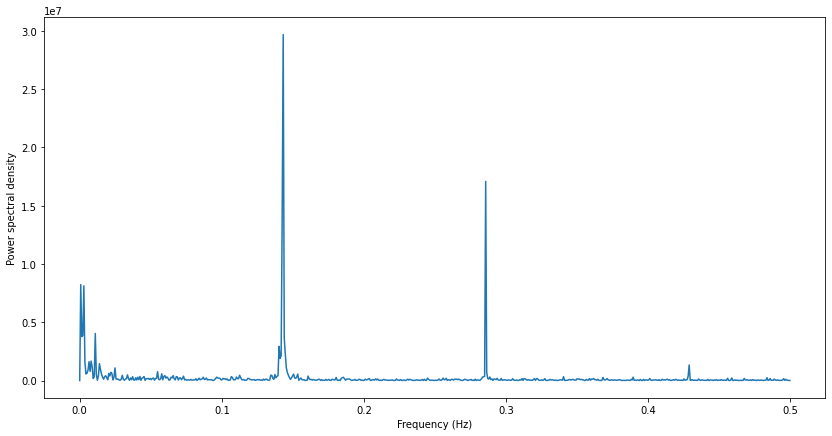

In [9]:
from scipy.signal import periodogram

freq, power = periodogram(record_by_date)
period = 1/freq[np.argmax(power)]
print(f"The period of the time series is {period}")

plt.figure(figsize=(14, 7))
plt.plot(freq, power)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density')
freq[np.argmax(power)]

Also it has to be noted that other python libraries may also have methods to obtain periodogram for a timeseries.

#Conclusion

In this study, we explored three different methods for finding the period of a time series in Pandas, using a real-life dataset as our source. As is typical with real-world data, the dataset contained some missing values and a periodicity that was not immediately obvious. However, we were able to identify the periodicity of the signal and confirm it using common sense.